https://www.kaggle.com/c/santander-value-prediction-challenge

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict
import math

In [4]:
TRAIN_DATA = 'data/santander/train.csv'
TEST_DATA = 'data/santander/test.csv'

# Setup training data

In [5]:
%%time
train_df =  pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)

print("Train rows and columns: ", train_df.shape)
print("Test rows and columns: ", test_df.shape)

Train rows and columns:  (4459, 4993)
Test rows and columns:  (49342, 4992)
Wall time: 52.7 s


In [6]:
%%time
os.makedirs('tmp', exist_ok=True)

train_df.to_feather('tmp/train_raw.feather')
test_df.to_feather('tmp/test_raw.feather')

Wall time: 5.22 s


In [7]:
%%time
train_df = pd.read_feather('tmp/train_raw.feather')
test_df = pd.read_feather('tmp/test_raw.feather')

Wall time: 2.05 s


In [8]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [10]:
train_df.drop('ID', axis=1, inplace=True)

In [11]:
y = np.log1p(train_df['target'])

In [12]:
X = train_df.drop('target', axis='columns')

# EDA

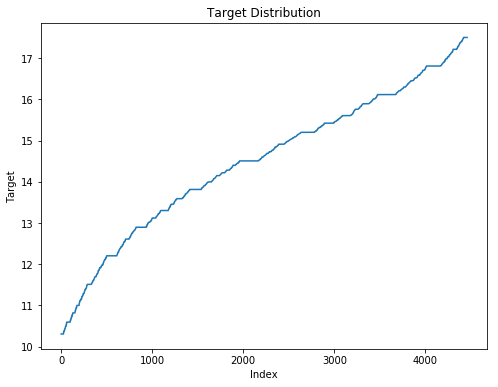

In [13]:
plt.figure(figsize=(8,6))
plt.plot(range(train_df.shape[0]), np.sort(y.values))
plt.xlabel('Index')
plt.ylabel('Target')
plt.title("Target Distribution")
plt.show()

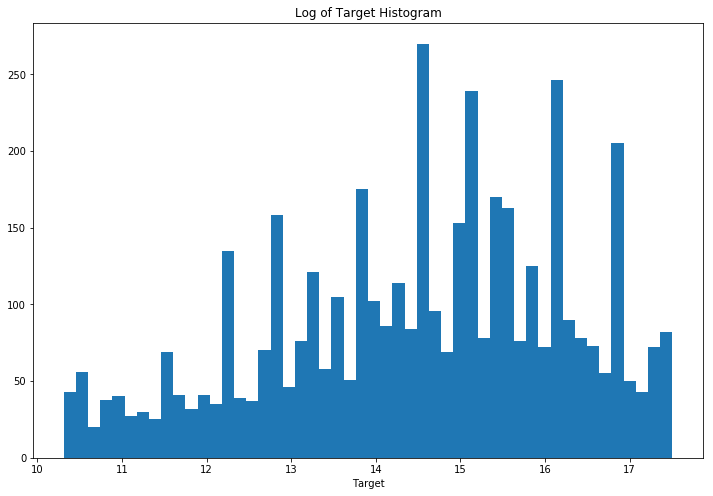

In [14]:
plt.figure(figsize=(12,8))
plt.hist(y.values, bins=50)
plt.xlabel('Target')
plt.title("Log of Target Histogram")
plt.show()

In [15]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845


# Random Forest

## Helper Functions

In [16]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [17]:
def print_score(m):  
    
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    
    train_rmse = rmse(m.predict(X_train), y_train)
    valid_rmse = rmse(m.predict(X_valid), y_valid)
    if hasattr(m, 'oob_score_'): oob_score = m.oob_score_
        
    res = f"Training-Score:   {train_score:.5f}\tTraining-rmse:\t   {train_rmse:.5f}\n"
    res += f"Validation-Score: {valid_score:.5f}\tValididation-rmse: {valid_rmse:.5f}\n"   
    if hasattr(m, 'oob_score_'): res += f"OOB-score:\t  {oob_score:.5f}"
        
    print(res)

In [18]:
def print_cv_score(scores):

    train_r2_scores = np.array(scores['train_r2'])    
    test_r2_scores = np.array(scores['test_r2'])
    train_rmse_scores = np.array(scores['train_neg_mean_squared_error'])
    test_rmse_scores = np.array(scores['test_neg_mean_squared_error'])
    
    train_score = train_r2_scores.mean()
    valid_score = test_r2_scores.mean()
    train_rmse = np.sqrt(train_rmse_scores * -1).mean()
    valid_rmse = np.sqrt(test_rmse_scores * -1).mean()

    res = f"Training-Score:   {train_score:.5f}\tTraining-rmse:\t   {train_rmse:.5f}\n"
    res += f"Validation-Score: {valid_score:.5f}\tValididation-rmse: {valid_rmse:.5f}\n"   
        
    print(res)

## Initial Model (50 trees)

In [19]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5, oob_score=True, n_jobs=-1)

## With Train-Test-Split

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [21]:
%%time
rf.fit(X_train, y_train)
print_score(rf)

Training-Score:   0.81681	Training-rmse:	   0.75407
Validation-Score: 0.30028	Valididation-rmse: 1.43629
OOB-score:	  0.30566
Wall time: 17.2 s


## With Cross Validation

In [22]:
%%time
scoring = ['r2','neg_mean_squared_error']
scores = cross_validate(rf, X, y, cv=5, scoring=scoring, return_train_score=True)
print_cv_score(scores)

Training-Score:   0.81417	Training-rmse:	   0.75462
Validation-Score: 0.32059	Valididation-rmse: 1.44185

Wall time: 1min 36s


## Train with Full Data (200 Trees)

In [27]:
rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=3, max_features=0.5, oob_score=True, n_jobs=-1)

In [28]:
%%time
rf.fit(X, y)

Wall time: 1min 30s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

# Predict and Submit

In [29]:
pred = rf.predict(test_df.drop('ID', axis=1))
pred = np.expm1(pred)

In [30]:
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [31]:
os.makedirs('submissions', exist_ok=True)
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred
sub_df.to_csv("submissions/v01_RF_Baseline.csv", index=False)